# Ideas for data generation

Create function that describes the integrated MM equation for a particular KM and Vmax

In [3]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np

##########################
### Set up equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                         


##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax



The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

Kcat/KM is: 2000.0


/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_56881/3924468723.py:50: RuntimeWarning: invalid value encountered in log10
  s = -np.log10(fraction_transmittance)


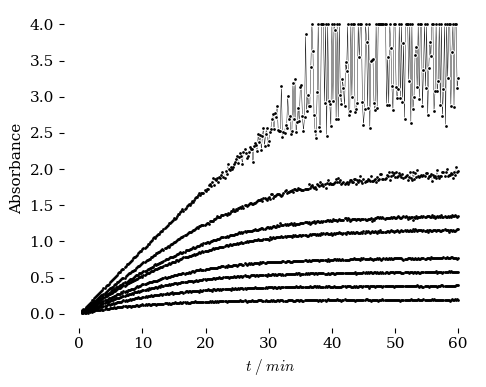

In [4]:
##############################################################################

time_end = 60           ### The end time
n_points = 360            ### number of points - increase if needed

#########################################
### Create series of time points      ###
#########################################

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(0.5, time_end+dt, dt) ### time vector (list of time points)

##########################
### Set up parameters
##########################

E_conc = 1e-9
KM_value = 0.05 / 1000          ### set KM value
kcat_value = 1E2 * 60          ### set kcat value in min^-1
S0_value = .1 / 1000            ### set initial substrate concentration value

print(f"Kcat/KM is: {kcat_value/60/(KM_value*1000):0.1f}")

Vmax_value = E_conc * kcat_value

plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


##########################
### calculate x and y data
##########################
S0_list = np.array([0.01,0.02,0.03,0.04,0.06,0.07,0.1,0.2]) / 1000
#S0_list = np.array([0.2]) / 1000

max_value = 4
for S0_value in S0_list:
    ### Calculate y according to the function
    s = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
    s = s + S0_value - S0_value * np.exp(-1E-3 * t_line)

#    s = S0_value - S0_value * np.exp(-1E-3 * t_line)

    ### the Lambert function produces imaginary numbers. Use on the real component
    s = np.real(s) * 18300   
    fraction_transmittance  = 1/(10**s)                              
    fraction_transmittance = np.random.normal(fraction_transmittance, 0.001, len(fraction_transmittance))
    s = -np.log10(fraction_transmittance)
    
    s = np.random.normal(s, 0.005, len(s))
    s[s > max_value] = max_value
    s = np.nan_to_num(s, copy=True, nan=max_value)   ### replace NaN with max value
    x = t_line; y = s

    ax.plot(x, y,
        linestyle = '-',            ### use a line between points
        linewidth='0.3',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )
    ax.scatter(x, y, 
        marker='o',                 ### Plot the x and y data 
        color='black',              ### markers are this color
        edgecolors = None,       ### outline of markers is this color
        linewidths = 0.5,           ### outline of markers is this wide
        s=2,                       ### "s" is "size". sqrt(64) = 8 points wide
        zorder = 2                  ### everything is in layer 1 (the top layer in this case)
        )
    ax.scatter(x, y, 
        marker='o',                 ### Plot the x and y data 
        color='white',              ### markers are this color
        edgecolors = None,       ### outline of markers is this color
        linewidths = 0.5,           ### outline of markers is this wide
        s=8,                       ### "s" is "size". sqrt(64) = 8 points wide
        zorder = 1                  ### everything is in layer 1 (the top layer in this case)
        )

ax.set( xlabel= r"$t\;/\;min$", 
        ylabel=r"Absorbance",
#        title = "NPA Hydrolysis",
#        xlim=[None, None],                  
#        ylim=[-.1, 4]      
       )
fig.tight_layout()         # otherwise the right y-label is slightly clipped
plt.savefig("plot.pdf")     ### export the plot as this
plt.show()



In [5]:
### List of kcat values for the enzyme in each lane (s^-1)
kcat_list = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100 ]
kcat_list = np.array(kcat_list)

### List of KM values for the enzyme in each lane (mM)
KM_list = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
KM_list = np.array(KM_list)

### List of the enzyme concentrations in each lane (nanomolar)
E_conc_list = [0, 0, 0, 1, 1, 1, 1/2, 1/2, 1/2, 1/4, 1/4, 1/4]
E_conc_list = np.array(E_conc_list) 

### List of Lane Names
lane_name_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

### List of the NPA conc in the eight wells of each lane (mM)
S_conc_list = [0.01,0.02,0.03,0.04,0.06,0.07,0.1,0.2]
S_conc_list = np.array(S_conc_list)

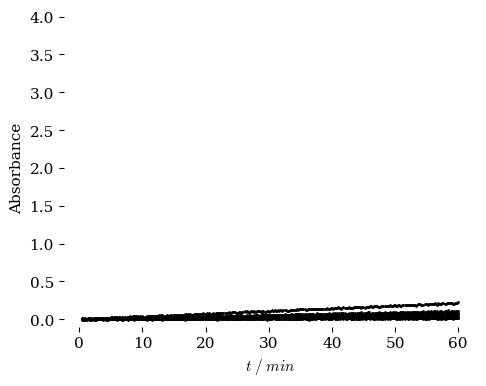

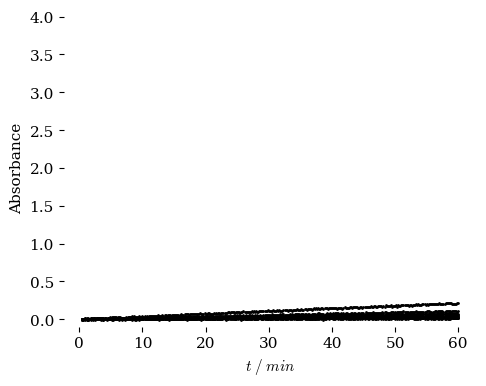

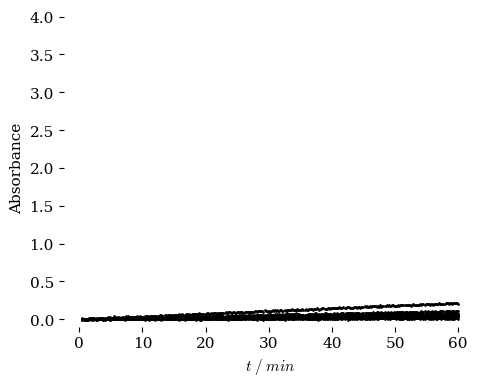

/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_56881/2275360786.py:37: RuntimeWarning: invalid value encountered in log10
  s = -np.log10(fraction_transmittance)


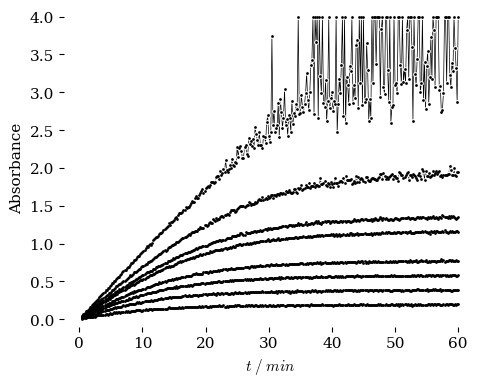

/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_56881/2275360786.py:37: RuntimeWarning: invalid value encountered in log10
  s = -np.log10(fraction_transmittance)


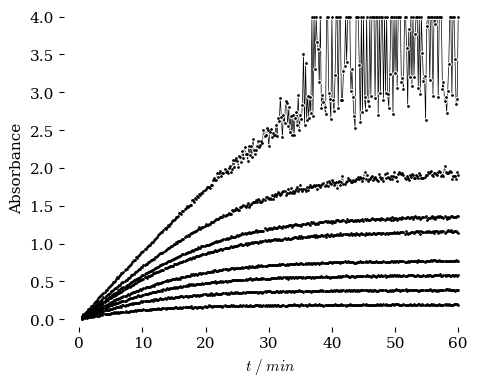

/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_56881/2275360786.py:37: RuntimeWarning: invalid value encountered in log10
  s = -np.log10(fraction_transmittance)


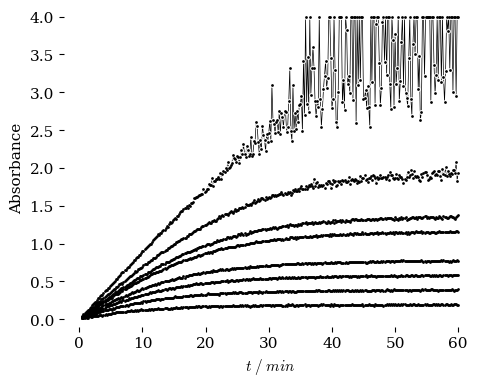

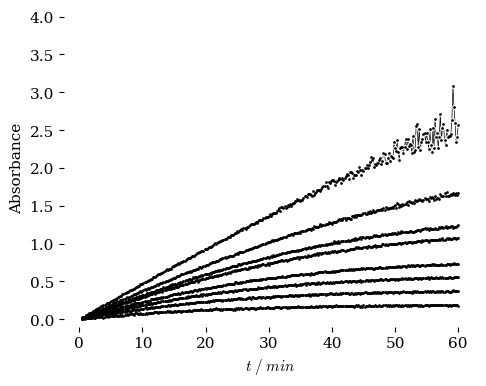

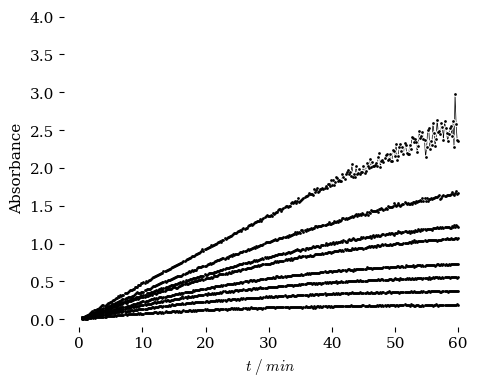

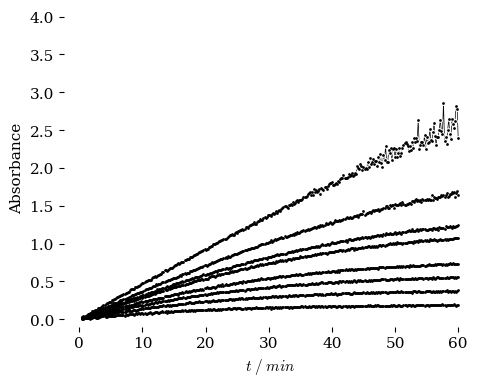

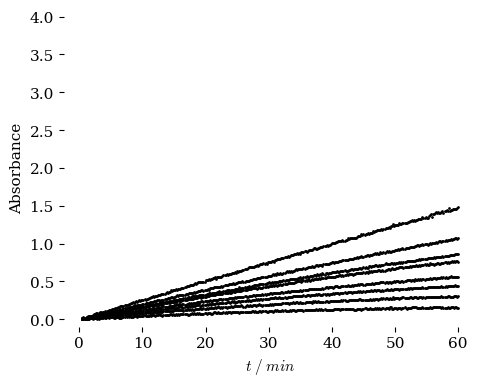

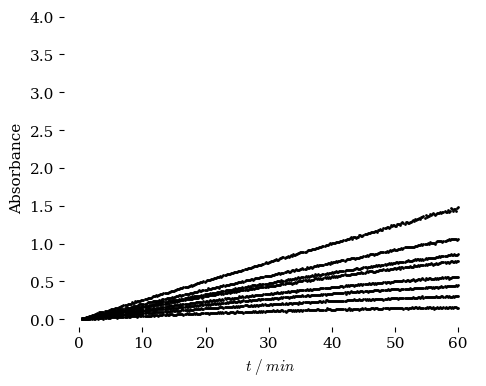

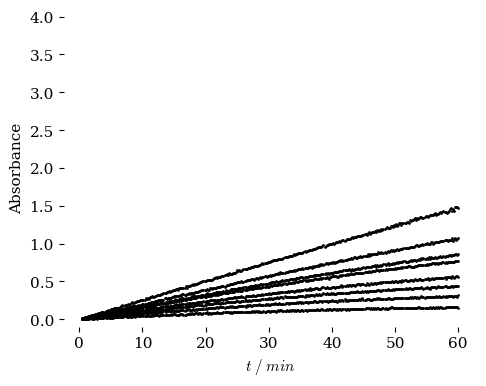

In [8]:
itr = zip(lane_name_list, kcat_list, KM_list, E_conc_list)

time_end = 60           ### The end time
n_points = 360            ### number of points - increase if needed

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(0.5, time_end+dt, dt) ### time vector (list of time points)

max_value = 4

for p in itr:
    lane_name, kcat_value, KM_value, E_conc = p      ### unpack kcat, KM and [E]
    kcat_value = kcat_value * 60
    KM_value = KM_value / 1000
    E_conc = E_conc / 1E9
#    print(lane_name, kcat_value, KM_value, E_conc)
    Vmax_value = kcat_value * E_conc

    plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
    plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  



    for S0_value in S_conc_list:
        ### Calculate y according to the function
        S0_value = S0_value/1000
        s_E = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
        s_E = np.real(s_E)
        s_NPA = S0_value - S0_value * np.exp(-1E-3 * t_line)
        s = s_E + s_NPA
        s = s * 18300   
        
        fraction_transmittance  = 1/(10**s)                              
        fraction_transmittance = np.random.normal(fraction_transmittance, 0.001, len(fraction_transmittance))
        s = -np.log10(fraction_transmittance)
        s = np.random.normal(s, 0.005, len(s))
        
        s[s > max_value] = max_value
        s = np.nan_to_num(s, copy=True, nan=max_value)   ### replace NaN with max value
        
        x = t_line; y = s
    
        ax.plot(x, y, linestyle = '-', linewidth='0.5', color = 'black', zorder = 0)
        ax.scatter(x, y, marker='o', color='black', edgecolors = None,      
            linewidths = 0.5, s=2, zorder = 2)
        ax.scatter(x, y, marker='o', color='white', edgecolors = None,      
            linewidths = 0.5, s=8, zorder = 1)
    
    ax.set( xlabel= r"$t\;/\;min$", 
            ylabel=r"Absorbance",
    #        title = "NPA Hydrolysis",
    #        xlim=[None, None],                  
            ylim=[-.1, 4.1]      
           )
    fig.tight_layout()         # otherwise the right y-label is slightly clipped
    plt.savefig("plot"+lane_name+".pdf")     ### export the plot as this
    plt.show()
